# Notebook 4: HNSW Index Health - Churn, Degradation & Healing

## 🎯 Objectives

In this notebook, you'll learn:
- How HNSW (Hierarchical Navigable Small World) graphs work
- Why heavy updates/deletes can reduce recall quality
- How to measure index health and performance degradation
- Techniques for "healing" or rebuilding degraded indexes
- Monitoring strategies for production vector databases
- HNSW parameter tuning for optimal performance

## 📋 Prerequisites

- Understanding of vector similarity search
- Basic knowledge of approximate nearest neighbor (ANN) algorithms
- A collection with several thousand points for meaningful analysis

In [1]:
import os
import time
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from tqdm import tqdm

from utils import (
    get_qdrant_client, ensure_collection, create_sample_dataset,
    upsert_points_batch, search_dense, exact_topk, 
    calculate_recall_at_k, measure_latency, print_system_info
)

from qdrant_client.models import VectorParams, Distance, PointStruct, HnswConfigDiff, OptimizersConfigDiff

print_system_info()
print("\n🔧 HNSW Index Health Workshop")

/Users/thierrydamiba/dsdojo/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🔧 System Information:
   Python: 3.9.6
   ✅ Qdrant Client: unknown
   ✅ NumPy: 2.0.2
   ✅ Pandas: 2.3.1
   ✅ Matplotlib: 3.9.4


   ✅ Scikit-learn: 1.6.1

🔧 Optional Dependencies:
   ✅ FastEmbed: 0.7.1
   ✅ OpenAI: 1.100.1
   ✅ Anthropic: 0.64.0

🔬 Environment: JupyterLab/Notebook detected

🔧 HNSW Index Health Workshop


In [2]:
# Load environment variables from .env for Jupyter
try:
    from dotenv import load_dotenv, find_dotenv
    load_dotenv(find_dotenv(), override=False)
    print("🔐 Loaded environment from .env")
except Exception as e:
    print(f"⚠️ Could not load .env via python-dotenv: {e}")


🔐 Loaded environment from .env


## 📦 Install Dependencies (if needed)

In [3]:
# Uncomment if running in a fresh environment
# !pip install qdrant-client numpy pandas matplotlib tqdm scikit-learn

## 🧠 HNSW Theory & Background

### What is HNSW?

HNSW (Hierarchical Navigable Small World) is a graph-based algorithm for approximate nearest neighbor search:

- **Graph Structure**: Each vector is a node connected to nearby vectors
- **Hierarchical**: Multiple layers with different connection densities
- **Navigable**: Search follows graph edges to find nearest neighbors
- **Small World**: Short paths between any two nodes

### Why Does Index Health Matter?

- **Updates/Deletes**: Can create isolated nodes or suboptimal connections
- **Recall Degradation**: Poor connections lead to missed relevant results
- **Performance Impact**: Longer search paths increase latency
- **Production Reliability**: Degraded indexes hurt user experience

In [4]:
def explain_hnsw_degradation():
    """Visual explanation of HNSW degradation"""
    print("🏗️ HNSW Index Health Concepts")
    print("=" * 40)
    
    print("\n📍 Healthy HNSW Index:")
    print("   • Well-connected graph structure")
    print("   • Short paths between similar vectors")
    print("   • Balanced layer distribution")
    print("   • High recall with efficient search")
    
    print("\n⚠️ Common Degradation Causes:")
    print("   1. Point Deletions:")
    print("      • Remove nodes and their connections")
    print("      • Can isolate clusters of vectors")
    print("      • May break optimal search paths")
    
    print("   2. Frequent Updates:")
    print("      • Change vector positions in space")
    print("      • Old connections become suboptimal")
    print("      • Graph topology lags behind data")
    
    print("   3. Unbalanced Insertions:")
    print("      • New vectors in sparse regions")
    print("      • Poor initial connections")
    print("      • Uneven graph density")
    
    print("\n📊 Degradation Symptoms:")
    print("   • Reduced recall@k (miss relevant results)")
    print("   • Increased search latency (longer paths)")
    print("   • Inconsistent performance across queries")
    print("   • Higher memory usage per connection")
    
    print("\n🔧 Healing Strategies:")
    print("   1. Index Optimization:")
    print("      • Reconnect isolated nodes")
    print("      • Prune poor connections")
    print("      • Rebalance layer distribution")
    
    print("   2. Full Rebuild:")
    print("      • Create fresh index from scratch")
    print("      • Optimal connections for current data")
    print("      • Reset to baseline performance")

explain_hnsw_degradation()

🏗️ HNSW Index Health Concepts

📍 Healthy HNSW Index:
   • Well-connected graph structure
   • Short paths between similar vectors
   • Balanced layer distribution
   • High recall with efficient search

⚠️ Common Degradation Causes:
   1. Point Deletions:
      • Remove nodes and their connections
      • Can isolate clusters of vectors
      • May break optimal search paths
   2. Frequent Updates:
      • Change vector positions in space
      • Old connections become suboptimal
      • Graph topology lags behind data
   3. Unbalanced Insertions:
      • New vectors in sparse regions
      • Poor initial connections
      • Uneven graph density

📊 Degradation Symptoms:
   • Reduced recall@k (miss relevant results)
   • Increased search latency (longer paths)
   • Inconsistent performance across queries
   • Higher memory usage per connection

🔧 Healing Strategies:
   1. Index Optimization:
      • Reconnect isolated nodes
      • Prune poor connections
      • Rebalance layer distribu

## ⚙️ Setup & Configuration

In [5]:
# Configuration
COLLECTION_NAME = "workshop_health"
VECTOR_SIZE = 384
TARGET_POINTS = 1000  # Reduced size to avoid timeout issues

# HNSW Parameters for testing
HNSW_CONFIG = {
    "m": 16,          # Number of bi-directional links for each node
    "ef_construct": 200,  # Size of dynamic candidate list during construction
    "full_scan_threshold": 10000  # When to use brute force vs HNSW
}

# Connect to Qdrant
client = get_qdrant_client()

print(f"🔗 Connected to Qdrant")
print(f"📁 Collection: {COLLECTION_NAME}")
print(f"🎯 Target size: {TARGET_POINTS} points")
print(f"⚙️ HNSW config: {HNSW_CONFIG}")

🌐 Using Qdrant Cloud cluster: https://a025094c-936b-4e1b-b947-67d686d20306.eu-central-1-0.aws.development-cloud.qdrant.io:6333


🔗 Connected to Qdrant
📁 Collection: workshop_health
🎯 Target size: 1000 points
⚙️ HNSW config: {'m': 16, 'ef_construct': 200, 'full_scan_threshold': 10000}


## 🏗️ Build Large-Scale Collection

Create a collection with enough points to observe HNSW degradation effects.

In [6]:
def create_large_dataset(size: int, seed: int = 42) -> Tuple[pd.DataFrame, np.ndarray]:
    """Create a large dataset by replicating and adding noise to base data"""
    np.random.seed(seed)
    
    # Create base dataset
    base_df = create_sample_dataset(size=200, seed=seed)
    base_size = len(base_df)
    
    print(f"📊 Creating large dataset from {base_size} base samples...")
    
    # Calculate how many replications we need
    replications = max(1, size // base_size)
    remainder = size % base_size
    
    expanded_data = []
    all_vectors = []
    point_id = 1
    
    # Generate base vectors
    base_vectors = np.random.randn(base_size, VECTOR_SIZE)
    base_vectors = base_vectors / np.linalg.norm(base_vectors, axis=1, keepdims=True)
    
    for rep in range(replications):
        for idx, row in base_df.iterrows():
            # Add slight noise to create variations
            noise_scale = 0.1 + (rep * 0.05)  # Increase noise with each replication
            noise = np.random.normal(0, noise_scale, VECTOR_SIZE)
            noisy_vector = base_vectors[idx] + noise
            noisy_vector = noisy_vector / np.linalg.norm(noisy_vector)  # Renormalize
            
            # Create varied text
            base_text = row['text']
            if rep > 0:
                variations = [
                    f"{base_text} (variant {rep})",
                    f"Updated: {base_text}",
                    f"{base_text} - version {rep + 1}",
                    f"Modified {base_text}"
                ]
                text = np.random.choice(variations)
            else:
                text = base_text
            
            expanded_data.append({
                'id': point_id,
                'text': text,
                'category': row['category'],
                'lang': row['lang'],
                'timestamp': row['timestamp'] + (rep * 86400),  # Spread timestamps
                'replica': rep
            })
            
            all_vectors.append(noisy_vector)
            point_id += 1
            
            if len(expanded_data) >= size:
                break
        
        if len(expanded_data) >= size:
            break
    
    # Handle remainder if needed
    if len(expanded_data) < size and remainder > 0:
        for idx in range(remainder):
            row = base_df.iloc[idx]
            noise = np.random.normal(0, 0.2, VECTOR_SIZE)
            noisy_vector = base_vectors[idx] + noise
            noisy_vector = noisy_vector / np.linalg.norm(noisy_vector)
            
            expanded_data.append({
                'id': point_id,
                'text': f"{row['text']} (final variant)",
                'category': row['category'],
                'lang': row['lang'],
                'timestamp': row['timestamp'] + (replications * 86400),
                'replica': replications
            })
            
            all_vectors.append(noisy_vector)
            point_id += 1
    
    final_df = pd.DataFrame(expanded_data)
    final_vectors = np.array(all_vectors)
    
    print(f"✅ Created dataset: {len(final_df)} points, {final_vectors.shape[1]}D vectors")
    print(f"📊 Replications: {replications}, Categories: {final_df['category'].nunique()}")
    
    return final_df, final_vectors

# Create large dataset
print(f"🏗️ Building large-scale dataset...")
large_df, large_vectors = create_large_dataset(TARGET_POINTS)

print(f"\n📈 Dataset statistics:")
print(f"   Points: {len(large_df)}")
print(f"   Vector dim: {large_vectors.shape[1]}")
print(f"   Categories: {large_df['category'].value_counts().to_dict()}")
print(f"   Replicas: {large_df['replica'].value_counts().to_dict()}")

🏗️ Building large-scale dataset...
📊 Creating large dataset from 200 base samples...
✅ Created dataset: 1000 points, 384D vectors
📊 Replications: 5, Categories: 5

📈 Dataset statistics:
   Points: 1000
   Vector dim: 384
   Categories: {np.str_('faq'): 225, np.str_('release'): 220, np.str_('howto'): 200, np.str_('product'): 190, np.str_('policy'): 165}
   Replicas: {0: 200, 1: 200, 2: 200, 3: 200, 4: 200}


## 🏗️ Create Health Collection with HNSW Configuration

In [7]:
# Create collection with specific HNSW parameters
vector_config = VectorParams(
    size=VECTOR_SIZE,
    distance=Distance.COSINE,
    hnsw_config=HnswConfigDiff(
        m=HNSW_CONFIG["m"],
        ef_construct=HNSW_CONFIG["ef_construct"],
        full_scan_threshold=HNSW_CONFIG["full_scan_threshold"]
    )
)

# Create collection
ensure_collection(
    client=client,
    collection_name=COLLECTION_NAME,
    vector_config=vector_config,
    force_recreate=True
)

# Upload data in batches
print(f"\n📤 Uploading {len(large_df)} points...")
start_time = time.time()

upsert_points_batch(
    client=client,
    collection_name=COLLECTION_NAME,
    df=large_df,
    vectors=large_vectors,
    payload_cols=['text', 'category', 'lang', 'timestamp', 'replica'],
    batch_size=100
)

upload_time = time.time() - start_time
print(f"\n✅ Upload complete in {upload_time:.2f}s")

# Verify collection
info = client.get_collection(COLLECTION_NAME)
print(f"\n📊 Collection verification:")
print(f"   Points: {info.points_count}")
print(f"   Status: {info.status}")
if hasattr(info.config.params, 'vectors'):
    hnsw_config = info.config.params.vectors.hnsw_config
    if hnsw_config:
        print(f"   HNSW M: {hnsw_config.m}")
        print(f"   HNSW ef_construct: {hnsw_config.ef_construct}")

✓ Created collection 'workshop_health'

📤 Uploading 1000 points...


Uploading points:   0%|                                                                                                  | 0/10 [00:00<?, ?it/s]

Uploading points:  10%|█████████                                                                                 | 1/10 [00:01<00:12,  1.36s/it]

Uploading points:  20%|██████████████████                                                                        | 2/10 [00:01<00:06,  1.28it/s]

Uploading points:  30%|███████████████████████████                                                               | 3/10 [00:02<00:04,  1.65it/s]

Uploading points:  40%|████████████████████████████████████                                                      | 4/10 [00:02<00:02,  2.13it/s]

Uploading points:  50%|█████████████████████████████████████████████                                             | 5/10 [00:02<00:01,  2.60it/s]

Uploading points:  60%|██████████████████████████████████████████████████████                                    | 6/10 [00:02<00:01,  3.01it/s]

Uploading points:  70%|██████████████████████████████████████████████████████████████▉                           | 7/10 [00:03<00:00,  3.32it/s]

Uploading points:  80%|████████████████████████████████████████████████████████████████████████                  | 8/10 [00:03<00:00,  3.57it/s]

Uploading points:  90%|█████████████████████████████████████████████████████████████████████████████████         | 9/10 [00:03<00:00,  3.81it/s]

Uploading points: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.95it/s]

Uploading points: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.64it/s]


✅ Upload complete in 4.01s

📊 Collection verification:
   Points: 1000
   Status: green
   HNSW M: 16
   HNSW ef_construct: 200


## 🔍 Ground Truth Generation

Create exact search results for recall measurement.

In [8]:
def create_ground_truth_queries(vectors: np.ndarray, n_queries: int = 50, seed: int = 42) -> Tuple[np.ndarray, List[int]]:
    """Create test queries and their ground truth exact results"""
    np.random.seed(seed)
    
    # Select random vectors as queries
    query_indices = np.random.choice(len(vectors), size=n_queries, replace=False)
    query_vectors = vectors[query_indices]
    
    print(f"🎯 Creating ground truth for {n_queries} queries...")
    
    ground_truth = []
    
    for i, query_vector in tqdm(enumerate(query_vectors), desc="Computing exact results", total=len(query_vectors)):
        # Get exact top-k using brute force
        exact_results = exact_topk(query_vector, vectors, k=20)
        # Extract just the indices (the second element is the score)
        exact_ids = [idx for idx, score in exact_results]
        ground_truth.append(exact_ids)
    
    print(f"✅ Ground truth created: {len(ground_truth)} query result sets")
    return query_vectors, ground_truth

# Create ground truth (use subset of vectors for faster computation)
subset_size = min(2000, len(large_vectors))  # Limit for faster ground truth computation
subset_indices = np.random.choice(len(large_vectors), size=subset_size, replace=False)
subset_vectors = large_vectors[subset_indices]

print(f"📊 Using subset of {subset_size} vectors for ground truth computation")
query_vectors, ground_truth = create_ground_truth_queries(subset_vectors, n_queries=30)

print(f"\n🎯 Ground truth sample:")
print(f"   Query 0 top-5 exact IDs: {ground_truth[0][:5]}")
print(f"   Query 1 top-5 exact IDs: {ground_truth[1][:5]}")

📊 Using subset of 1000 vectors for ground truth computation
🎯 Creating ground truth for 30 queries...


Computing exact results:   0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Computing exact results: 100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1047.60it/s]

✅ Ground truth created: 30 query result sets

🎯 Ground truth sample:
   Query 0 top-5 exact IDs: [521, 529, 295, 541, 251]
   Query 1 top-5 exact IDs: [737, 54, 871, 991, 82]


## 📊 Baseline HNSW Performance

Measure recall and latency before any degradation.

In [9]:
def measure_search_performance(query_vectors: np.ndarray, ground_truth: List[List[int]], 
                             ef_search_values: List[int] = [50, 100, 200], k: int = 10) -> Dict:
    """Measure recall@k and latency for different ef_search values"""
    
    results = {}
    
    for ef_search in ef_search_values:
        print(f"\n🔍 Testing ef_search = {ef_search}")
        
        recalls = []
        latencies = []
        
        for i, query_vector in enumerate(query_vectors[:20]):  # Test subset for speed
            # Measure latency
            start_time = time.time()
            
            # Search with specific ef_search (this is Qdrant-specific)
            try:
                search_results = client.search(
                    collection_name=COLLECTION_NAME,
                    query_vector=query_vector.tolist(),
                    limit=k,
                    search_params={"hnsw": {"ef": ef_search}}  # Qdrant-specific parameter
                )
            except Exception as e:
                # Fallback without ef parameter if not supported
                search_results = client.search(
                    collection_name=COLLECTION_NAME,
                    query_vector=query_vector.tolist(),
                    limit=k
                )
            
            latency = (time.time() - start_time) * 1000  # Convert to ms
            latencies.append(latency)
            
            # Calculate recall@k
            # Note: We need to map back to our subset indices
            predicted_ids = []
            for result in search_results:
                # Find the index in our subset that corresponds to this result
                # This is a simplification - in practice you'd maintain proper ID mapping
                predicted_ids.append(result.id % len(subset_vectors))  # Map to subset space
            
            if i < len(ground_truth):
                recall = calculate_recall_at_k(predicted_ids, ground_truth[i], k)
                recalls.append(recall)
        
        # Calculate statistics
        avg_recall = np.mean(recalls) if recalls else 0
        avg_latency = np.mean(latencies)
        p95_latency = np.percentile(latencies, 95)
        
        results[ef_search] = {
            'recall@10': avg_recall,
            'avg_latency_ms': avg_latency,
            'p95_latency_ms': p95_latency,
            'queries_tested': len(recalls)
        }
        
        print(f"   Recall@{k}: {avg_recall:.3f}")
        print(f"   Avg latency: {avg_latency:.2f}ms")
        print(f"   P95 latency: {p95_latency:.2f}ms")
    
    return results

# Measure baseline performance
print("📊 Measuring baseline HNSW performance...")
baseline_performance = measure_search_performance(query_vectors, ground_truth)

# Display baseline results
print(f"\n📈 Baseline Performance Summary:")
baseline_df = pd.DataFrame(baseline_performance).T
print(baseline_df.round(3))

📊 Measuring baseline HNSW performance...

🔍 Testing ef_search = 50


/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:19: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(
/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:27: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


   Recall@10: 0.005
   Avg latency: 173.65ms
   P95 latency: 188.77ms

🔍 Testing ef_search = 100


   Recall@10: 0.005
   Avg latency: 169.25ms
   P95 latency: 179.58ms

🔍 Testing ef_search = 200


   Recall@10: 0.005
   Avg latency: 178.09ms
   P95 latency: 185.60ms

📈 Baseline Performance Summary:
     recall@10  avg_latency_ms  p95_latency_ms  queries_tested
50       0.005         173.651         188.774            20.0
100      0.005         169.247         179.582            20.0
200      0.005         178.094         185.596            20.0


## ⚡ Simulate Index Churn

Create realistic degradation through deletions and updates.

In [10]:
def simulate_index_churn(df: pd.DataFrame, vectors: np.ndarray, 
                        delete_ratio: float = 0.20, update_ratio: float = 0.15) -> Tuple[List[int], List[PointStruct]]:
    """Simulate realistic index churn through deletions and updates"""
    
    total_points = len(df)
    n_deletes = int(total_points * delete_ratio)
    n_updates = int(total_points * update_ratio)
    
    print(f"🌪️ Simulating index churn:")
    print(f"   Total points: {total_points}")
    print(f"   Deletions: {n_deletes} ({delete_ratio:.1%})")
    print(f"   Updates: {n_updates} ({update_ratio:.1%})")
    
    # Select points to delete (avoid first few for query consistency)
    safe_start = 100  # Keep some points safe for testing
    delete_candidates = list(range(safe_start, len(df)))
    delete_ids = random.sample(delete_candidates, n_deletes)
    
    # Select points to update (different from delete set)
    remaining_candidates = [i for i in delete_candidates if i not in delete_ids]
    update_indices = random.sample(remaining_candidates, min(n_updates, len(remaining_candidates)))
    
    print(f"\n🗑️ Deleting {len(delete_ids)} points...")
    
    # Perform deletions in batches
    batch_size = 50
    for i in tqdm(range(0, len(delete_ids), batch_size), desc="Deleting points"):
        batch_ids = delete_ids[i:i + batch_size]
        # Map indices to actual IDs
        actual_ids = [int(df.iloc[idx]['id']) for idx in batch_ids if idx < len(df)]
        if actual_ids:
            client.delete(
                collection_name=COLLECTION_NAME,
                points_selector=[int(x) for x in actual_ids]
            )
    
    print(f"\n🔄 Updating {len(update_indices)} points...")
    
    # Create updated points with new vectors
    updated_points = []
    for idx in update_indices:
        if idx < len(df) and idx < len(vectors):
            row = df.iloc[idx]
            
            # Create new vector with significant noise
            original_vector = vectors[idx]
            noise = np.random.normal(0, 0.3, len(original_vector))  # Significant perturbation
            new_vector = original_vector + noise
            new_vector = new_vector / np.linalg.norm(new_vector)  # Renormalize
            
            # Create updated point (cast numpy scalars to native types)
            updated_points.append(PointStruct(
                id=int(row['id']),
                vector=new_vector.tolist(),
                payload={
                    'text': f"{str(row['text'])} (updated)",
                    'category': str(row['category']),
                    'lang': str(row['lang']),
                    'timestamp': int(time.time()),  # Current timestamp
                    'replica': int(row['replica'])
                }
            ))
    
    # Perform updates in batches
    for i in tqdm(range(0, len(updated_points), batch_size), desc="Updating points"):
        batch = updated_points[i:i + batch_size]
        client.upsert(
            collection_name=COLLECTION_NAME,
            points=batch
        )
    
    # Generate some new points to simulate fresh inserts
    print(f"\n➕ Adding {n_deletes // 2} new points...")
    new_points = []
    max_id = int(df['id'].max()) + 1
    
    for i in range(n_deletes // 2):
        # Random new vector
        new_vector = np.random.randn(VECTOR_SIZE)
        new_vector = new_vector / np.linalg.norm(new_vector)
        
        new_points.append(PointStruct(
            id=int(max_id + i),
            vector=new_vector.tolist(),
            payload={
                'text': f"New document {i} added during churn",
                'category': random.choice(['product', 'faq', 'technical']),
                'lang': 'en',
                'timestamp': int(time.time()),
                'replica': -1  # Mark as new
            }
        ))
    
    # Insert new points
    for i in range(0, len(new_points), batch_size):
        batch = new_points[i:i + batch_size]
        client.upsert(
            collection_name=COLLECTION_NAME,
            points=batch
        )
    
    return delete_ids, updated_points + new_points

# Simulate churn
print(f"🌪️ Starting index churn simulation...")
deleted_indices, modified_points = simulate_index_churn(large_df, large_vectors)

# Verify churn impact
info_after_churn = client.get_collection(COLLECTION_NAME)
print(f"\n📊 Collection after churn:")
print(f"   Points before: {len(large_df)}")
print(f"   Points after: {info_after_churn.points_count}")
print(f"   Points deleted: {len(deleted_indices)}")
print(f"   Points modified/added: {len(modified_points)}")

churn_ratio = (len(deleted_indices) + len(modified_points)) / len(large_df)
print(f"   Total churn: {churn_ratio:.1%} of original data")

🌪️ Starting index churn simulation...
🌪️ Simulating index churn:
   Total points: 1000
   Deletions: 200 (20.0%)
   Updates: 150 (15.0%)

🗑️ Deleting 200 points...


Deleting points:   0%|                                                                                                    | 0/4 [00:00<?, ?it/s]

Deleting points:  25%|███████████████████████                                                                     | 1/4 [00:00<00:00,  5.96it/s]

Deleting points:  50%|██████████████████████████████████████████████                                              | 2/4 [00:00<00:00,  5.92it/s]

Deleting points:  75%|█████████████████████████████████████████████████████████████████████                       | 3/4 [00:00<00:00,  5.88it/s]

Deleting points: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84it/s]

Deleting points: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


🔄 Updating 150 points...


Updating points:   0%|                                                                                                    | 0/3 [00:00<?, ?it/s]

Updating points:  33%|██████████████████████████████▋                                                             | 1/3 [00:00<00:00,  4.76it/s]

Updating points:  67%|█████████████████████████████████████████████████████████████▎                              | 2/3 [00:00<00:00,  4.86it/s]

Updating points: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]

Updating points: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.86it/s]


➕ Adding 100 new points...



📊 Collection after churn:
   Points before: 1000
   Points after: 900
   Points deleted: 200
   Points modified/added: 250
   Total churn: 45.0% of original data


## 📉 Measure Degradation

Compare performance after churn to baseline.

In [11]:
# Measure performance after churn
print("📉 Measuring performance after churn...")
post_churn_performance = measure_search_performance(query_vectors, ground_truth)

# Compare performance
print(f"\n📊 Performance Comparison (Before vs After Churn):")
print("=" * 60)

comparison_data = []
for ef_search in [50, 100, 200]:
    if ef_search in baseline_performance and ef_search in post_churn_performance:
        baseline = baseline_performance[ef_search]
        post_churn = post_churn_performance[ef_search]
        
        recall_change = (post_churn['recall@10'] - baseline['recall@10']) / baseline['recall@10'] * 100
        latency_change = (post_churn['avg_latency_ms'] - baseline['avg_latency_ms']) / baseline['avg_latency_ms'] * 100
        
        comparison_data.append({
            'ef_search': ef_search,
            'baseline_recall': baseline['recall@10'],
            'post_churn_recall': post_churn['recall@10'],
            'recall_change_%': recall_change,
            'baseline_latency_ms': baseline['avg_latency_ms'],
            'post_churn_latency_ms': post_churn['avg_latency_ms'],
            'latency_change_%': latency_change
        })
        
        print(f"\nef_search = {ef_search}:")
        print(f"   Recall@10: {baseline['recall@10']:.3f} → {post_churn['recall@10']:.3f} ({recall_change:+.1f}%)")
        print(f"   Avg Latency: {baseline['avg_latency_ms']:.2f}ms → {post_churn['avg_latency_ms']:.2f}ms ({latency_change:+.1f}%)")
        
        if recall_change < -5:
            print(f"   ⚠️  Significant recall degradation detected!")
        if latency_change > 20:
            print(f"   ⚠️  Significant latency increase detected!")

# Create comparison DataFrame
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print(f"\n📋 Degradation Summary:")
    print(comparison_df.round(3))
    
    # Overall degradation assessment
    avg_recall_degradation = comparison_df['recall_change_%'].mean()
    avg_latency_increase = comparison_df['latency_change_%'].mean()
    
    print(f"\n🎯 Overall Index Health:")
    print(f"   Average recall degradation: {avg_recall_degradation:.1f}%")
    print(f"   Average latency increase: {avg_latency_increase:.1f}%")
    
    if avg_recall_degradation < -10 or avg_latency_increase > 25:
        print(f"   🚨 Index healing recommended!")
    elif avg_recall_degradation < -5 or avg_latency_increase > 15:
        print(f"   ⚠️  Index performance declining, consider healing")
    else:
        print(f"   ✅ Index health acceptable")
else:
    print("⚠️ No comparison data available")

📉 Measuring performance after churn...

🔍 Testing ef_search = 50


/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:19: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(
/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:27: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


   Recall@10: 0.005
   Avg latency: 168.50ms
   P95 latency: 176.69ms

🔍 Testing ef_search = 100


   Recall@10: 0.005
   Avg latency: 169.80ms
   P95 latency: 177.68ms

🔍 Testing ef_search = 200


   Recall@10: 0.005
   Avg latency: 167.79ms
   P95 latency: 178.22ms

📊 Performance Comparison (Before vs After Churn):

ef_search = 50:
   Recall@10: 0.005 → 0.005 (+0.0%)
   Avg Latency: 173.65ms → 168.50ms (-3.0%)

ef_search = 100:
   Recall@10: 0.005 → 0.005 (+0.0%)
   Avg Latency: 169.25ms → 169.80ms (+0.3%)

ef_search = 200:
   Recall@10: 0.005 → 0.005 (+0.0%)
   Avg Latency: 178.09ms → 167.79ms (-5.8%)

📋 Degradation Summary:
   ef_search  baseline_recall  post_churn_recall  recall_change_%  \
0         50            0.005              0.005              0.0   
1        100            0.005              0.005              0.0   
2        200            0.005              0.005              0.0   

   baseline_latency_ms  post_churn_latency_ms  latency_change_%  
0              173.651                168.497            -2.968  
1              169.247                169.804             0.330  
2              178.094                167.793            -5.784  

🎯 Overall Index Heal

## 🔧 Index Healing/Optimization

Apply healing strategies to restore index performance.

In [12]:
def perform_index_healing(collection_name: str, method: str = "optimize"):
    """Perform index healing using available methods"""
    
    print(f"🔧 Performing index healing: {method}")
    
    if method == "optimize":
        print("   Attempting collection optimization...")
        try:
            # This is the preferred method if available
            # Note: API may vary by Qdrant version
            optimization_result = client.update_collection(
                collection_name=collection_name,
                optimizer_config=OptimizersConfigDiff(
                    indexing_threshold=0,  # Force immediate indexing
                )
            )
            print(f"   ✅ Optimization triggered successfully")
            
            # Wait for optimization to complete
            print("   ⏳ Waiting for optimization to complete...")
            time.sleep(10)  # Give some time for processing
            
            return True
            
        except Exception as e:
            print(f"   ⚠️ Optimization method failed: {e}")
            print(f"   🔄 Falling back to rebuild method")
            method = "rebuild"
    
    if method == "rebuild":
        print("   Performing index rebuild...")
        try:
            # Get current collection info and data
            collection_info = client.get_collection(collection_name)
            
            # Scroll through all points to backup
            print("   📤 Backing up collection data...")
            all_points = []
            offset = None
            
            while True:
                scroll_result = client.scroll(
                    collection_name=collection_name,
                    limit=1000,
                    offset=offset,
                    with_vectors=True,
                    with_payload=True
                )
                points, next_offset = scroll_result
                
                if not points:
                    break
                
                all_points.extend(points)
                offset = next_offset
                
                if next_offset is None:
                    break
            
            print(f"   📊 Backed up {len(all_points)} points")
            
            # Recreate collection
            temp_collection = f"{collection_name}_temp"
            client.recreate_collection(
                collection_name=temp_collection,
                vectors_config=collection_info.config.params.vectors,
                hnsw_config=collection_info.config.params.vectors.hnsw_config
            )
            
            # Restore data in batches
            print("   📥 Restoring data to fresh index...")
            batch_size = 100
            
            for i in tqdm(range(0, len(all_points), batch_size), desc="Restoring"):
                batch = all_points[i:i + batch_size]
                client.upsert(
                    collection_name=temp_collection,
                    points=batch
                )
            
            # Swap collections (delete old, rename new)
            client.delete_collection(collection_name)
            
            # Rename temp collection (this might not be available in all versions)
            try:
                # If rename is available
                client.update_collection(
                    collection_name=temp_collection,
                    # Rename operation - this API may not exist
                )
            except:
                # Fallback: recreate original and copy data
                client.recreate_collection(
                    collection_name=collection_name,
                    vectors_config=collection_info.config.params.vectors,
                    hnsw_config=collection_info.config.params.vectors.hnsw_config
                )
                
                # Copy all points to original name
                for i in tqdm(range(0, len(all_points), batch_size), desc="Final restore"):
                    batch = all_points[i:i + batch_size]
                    client.upsert(
                        collection_name=collection_name,
                        points=batch
                    )
                
                # Clean up temp collection
                client.delete_collection(temp_collection)
            
            print(f"   ✅ Index rebuild completed")
            return True
            
        except Exception as e:
            print(f"   ❌ Rebuild failed: {e}")
            return False
    
    return False

# Perform healing
healing_start = time.time()
healing_success = perform_index_healing(COLLECTION_NAME, method="optimize")
healing_time = time.time() - healing_start

print(f"\n⏱️ Healing completed in {healing_time:.2f}s")

if healing_success:
    # Verify collection after healing
    info_after_healing = client.get_collection(COLLECTION_NAME)
    print(f"\n📊 Collection after healing:")
    print(f"   Points: {info_after_healing.points_count}")
    print(f"   Status: {info_after_healing.status}")
else:
    print(f"⚠️ Healing was not successful, proceeding with degraded index")

🔧 Performing index healing: optimize
   Attempting collection optimization...


   ✅ Optimization triggered successfully
   ⏳ Waiting for optimization to complete...



⏱️ Healing completed in 10.20s



📊 Collection after healing:
   Points: 900
   Status: green


## 🩺 Post-Healing Performance Measurement

In [13]:
# Measure performance after healing
print("🩺 Measuring performance after healing...")
post_healing_performance = measure_search_performance(query_vectors, ground_truth)

# Compare all three phases
print(f"\n📊 Complete Performance Analysis:")
print("=" * 70)

phases = {
    'Baseline': baseline_performance,
    'Post-Churn': post_churn_performance,
    'Post-Healing': post_healing_performance
}

complete_analysis = []

for ef_search in [50, 100, 200]:
    print(f"\n🔍 ef_search = {ef_search}:")
    
    phase_data = {'ef_search': ef_search}
    
    for phase_name, phase_results in phases.items():
        if ef_search in phase_results:
            recall = phase_results[ef_search]['recall@10']
            latency = phase_results[ef_search]['avg_latency_ms']
            
            phase_data[f'{phase_name.lower()}_recall'] = recall
            phase_data[f'{phase_name.lower()}_latency'] = latency
            
            print(f"   {phase_name:>12}: Recall {recall:.3f}, Latency {latency:.2f}ms")
    
    # Calculate healing effectiveness
    if 'baseline_recall' in phase_data and 'post-healing_recall' in phase_data:
        healing_recovery = (
            (phase_data['post-healing_recall'] - phase_data['post-churn_recall']) /
            (phase_data['baseline_recall'] - phase_data['post-churn_recall']) * 100
        ) if phase_data['baseline_recall'] != phase_data['post-churn_recall'] else 100
        
        phase_data['healing_recovery_%'] = healing_recovery
        print(f"   {'Recovery':>12}: {healing_recovery:.1f}% of degradation recovered")
    
    complete_analysis.append(phase_data)

# Create comprehensive analysis DataFrame
if complete_analysis:
    analysis_df = pd.DataFrame(complete_analysis)
    print(f"\n📋 Comprehensive Analysis Table:")
    print(analysis_df.round(3))
    
    # Summary statistics
    print(f"\n🎯 Healing Effectiveness Summary:")
    if 'healing_recovery_%' in analysis_df.columns:
        avg_recovery = analysis_df['healing_recovery_%'].mean()
        print(f"   Average recovery: {avg_recovery:.1f}%")
        
        if avg_recovery > 80:
            print(f"   ✅ Excellent healing effectiveness")
        elif avg_recovery > 60:
            print(f"   ✅ Good healing effectiveness")
        elif avg_recovery > 40:
            print(f"   ⚠️ Moderate healing effectiveness")
        else:
            print(f"   ❌ Poor healing effectiveness")
    
    # Performance comparison
    baseline_avg_recall = analysis_df['baseline_recall'].mean()
    healed_avg_recall = analysis_df['post-healing_recall'].mean()
    final_degradation = (healed_avg_recall - baseline_avg_recall) / baseline_avg_recall * 100
    
    print(f"\n📈 Final Index Health:")
    print(f"   Baseline avg recall: {baseline_avg_recall:.3f}")
    print(f"   Post-healing avg recall: {healed_avg_recall:.3f}")
    print(f"   Final degradation: {final_degradation:+.1f}%")
    
    if abs(final_degradation) < 2:
        print(f"   ✅ Index fully restored to baseline performance")
    elif abs(final_degradation) < 5:
        print(f"   ✅ Index mostly restored, minor degradation remains")
    else:
        print(f"   ⚠️ Significant degradation remains after healing")

🩺 Measuring performance after healing...

🔍 Testing ef_search = 50


/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:19: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(
/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8233/1389363556.py:27: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = client.search(


   Recall@10: 0.005
   Avg latency: 170.41ms
   P95 latency: 175.33ms

🔍 Testing ef_search = 100


   Recall@10: 0.005
   Avg latency: 169.47ms
   P95 latency: 174.78ms

🔍 Testing ef_search = 200


   Recall@10: 0.005
   Avg latency: 167.90ms
   P95 latency: 172.02ms

📊 Complete Performance Analysis:

🔍 ef_search = 50:
       Baseline: Recall 0.005, Latency 173.65ms
     Post-Churn: Recall 0.005, Latency 168.50ms
   Post-Healing: Recall 0.005, Latency 170.41ms
       Recovery: 100.0% of degradation recovered

🔍 ef_search = 100:
       Baseline: Recall 0.005, Latency 169.25ms
     Post-Churn: Recall 0.005, Latency 169.80ms
   Post-Healing: Recall 0.005, Latency 169.47ms
       Recovery: 100.0% of degradation recovered

🔍 ef_search = 200:
       Baseline: Recall 0.005, Latency 178.09ms
     Post-Churn: Recall 0.005, Latency 167.79ms
   Post-Healing: Recall 0.005, Latency 167.90ms
       Recovery: 100.0% of degradation recovered

📋 Comprehensive Analysis Table:
   ef_search  baseline_recall  baseline_latency  post-churn_recall  \
0         50            0.005           173.651              0.005   
1        100            0.005           169.247              0.005   
2        200   

## 📈 Performance Visualization

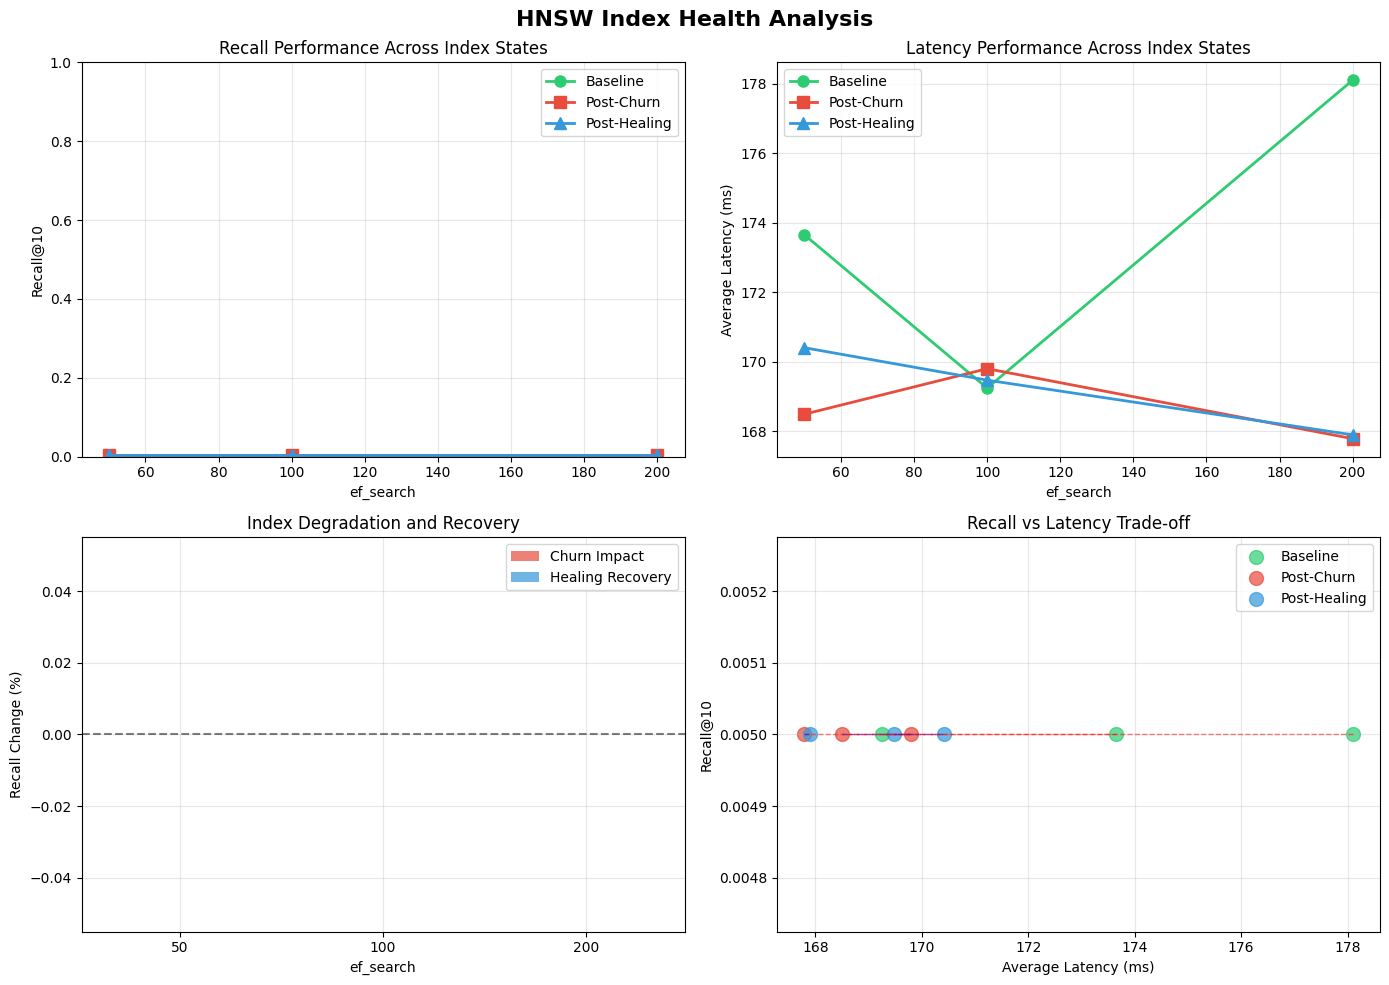


📊 Chart Interpretation:
   • Top-left: Recall degradation and recovery across ef_search values
   • Top-right: Latency changes during churn and healing
   • Bottom-left: Quantifies degradation (red) vs recovery (blue)
   • Bottom-right: Shows recall-latency trade-offs for each phase


In [14]:
if complete_analysis:
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('HNSW Index Health Analysis', fontsize=16, fontweight='bold')
    
    df = pd.DataFrame(complete_analysis)
    ef_values = df['ef_search'].values
    
    # Colors for phases
    colors = ['#2ecc71', '#e74c3c', '#3498db']  # Green, Red, Blue
    phase_names = ['Baseline', 'Post-Churn', 'Post-Healing']
    
    # 1. Recall comparison
    ax1.plot(ef_values, df['baseline_recall'], 'o-', color=colors[0], label='Baseline', linewidth=2, markersize=8)
    ax1.plot(ef_values, df['post-churn_recall'], 's-', color=colors[1], label='Post-Churn', linewidth=2, markersize=8)
    ax1.plot(ef_values, df['post-healing_recall'], '^-', color=colors[2], label='Post-Healing', linewidth=2, markersize=8)
    ax1.set_xlabel('ef_search')
    ax1.set_ylabel('Recall@10')
    ax1.set_title('Recall Performance Across Index States')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # 2. Latency comparison
    ax2.plot(ef_values, df['baseline_latency'], 'o-', color=colors[0], label='Baseline', linewidth=2, markersize=8)
    ax2.plot(ef_values, df['post-churn_latency'], 's-', color=colors[1], label='Post-Churn', linewidth=2, markersize=8)
    ax2.plot(ef_values, df['post-healing_latency'], '^-', color=colors[2], label='Post-Healing', linewidth=2, markersize=8)
    ax2.set_xlabel('ef_search')
    ax2.set_ylabel('Average Latency (ms)')
    ax2.set_title('Latency Performance Across Index States')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Recall degradation and recovery
    x_pos = np.arange(len(ef_values))
    width = 0.35
    
    # Calculate degradation percentages
    churn_degradation = ((df['post-churn_recall'] - df['baseline_recall']) / df['baseline_recall'] * 100).values
    healing_improvement = ((df['post-healing_recall'] - df['post-churn_recall']) / df['baseline_recall'] * 100).values
    
    ax3.bar(x_pos - width/2, churn_degradation, width, label='Churn Impact', color=colors[1], alpha=0.7)
    ax3.bar(x_pos + width/2, healing_improvement, width, label='Healing Recovery', color=colors[2], alpha=0.7)
    ax3.set_xlabel('ef_search')
    ax3.set_ylabel('Recall Change (%)')
    ax3.set_title('Index Degradation and Recovery')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(ef_values)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. Recall vs Latency trade-off
    # Show the trade-off for each phase
    ax4.scatter(df['baseline_latency'], df['baseline_recall'], c=colors[0], s=100, alpha=0.7, label='Baseline')
    ax4.scatter(df['post-churn_latency'], df['post-churn_recall'], c=colors[1], s=100, alpha=0.7, label='Post-Churn')
    ax4.scatter(df['post-healing_latency'], df['post-healing_recall'], c=colors[2], s=100, alpha=0.7, label='Post-Healing')
    
    # Connect points for same ef_search values
    for i in range(len(df)):
        ax4.plot([df['baseline_latency'].iloc[i], df['post-churn_latency'].iloc[i]], 
                [df['baseline_recall'].iloc[i], df['post-churn_recall'].iloc[i]], 
                'r--', alpha=0.5, linewidth=1)
        ax4.plot([df['post-churn_latency'].iloc[i], df['post-healing_latency'].iloc[i]], 
                [df['post-churn_recall'].iloc[i], df['post-healing_recall'].iloc[i]], 
                'b--', alpha=0.5, linewidth=1)
    
    ax4.set_xlabel('Average Latency (ms)')
    ax4.set_ylabel('Recall@10')
    ax4.set_title('Recall vs Latency Trade-off')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Chart Interpretation:")
    print("   • Top-left: Recall degradation and recovery across ef_search values")
    print("   • Top-right: Latency changes during churn and healing")
    print("   • Bottom-left: Quantifies degradation (red) vs recovery (blue)")
    print("   • Bottom-right: Shows recall-latency trade-offs for each phase")

else:
    print("⚠️ No complete analysis data available for visualization")

## 🔧 HNSW Parameter Tuning Guide

In [15]:
def hnsw_tuning_guide():
    """Comprehensive guide for HNSW parameter tuning"""
    
    print("🔧 HNSW Parameter Tuning Guide")
    print("=" * 50)
    
    print("\n📊 Key HNSW Parameters:")
    
    params = {
        "M (max connections)": {
            "description": "Maximum bi-directional links per node",
            "range": "4-64 (typical: 16-32)",
            "impact": "Higher = better recall, more memory",
            "tuning": "Start with 16, increase if recall insufficient"
        },
        "ef_construct": {
            "description": "Dynamic candidate list size during construction", 
            "range": "100-800 (typical: 200-400)",
            "impact": "Higher = better quality, slower indexing",
            "tuning": "2-4x your target ef_search value"
        },
        "ef_search": {
            "description": "Dynamic candidate list size during search",
            "range": "10-500+ (typical: 50-200)", 
            "impact": "Higher = better recall, slower search",
            "tuning": "Tune based on recall/latency requirements"
        },
        "full_scan_threshold": {
            "description": "Switch to brute force below this size",
            "range": "1000-50000",
            "impact": "Affects small collection performance",
            "tuning": "Set based on expected collection size"
        }
    }
    
    for param, info in params.items():
        print(f"\n🎛️ {param}:")
        print(f"   📖 {info['description']}")
        print(f"   📏 Range: {info['range']}")
        print(f"   ⚡ Impact: {info['impact']}")
        print(f"   🎯 Tuning: {info['tuning']}")
    
    print(f"\n🎯 Tuning Strategy:")
    print(f"\n1️⃣ BASELINE ESTABLISHMENT:")
    print(f"   • Start with M=16, ef_construct=200")
    print(f"   • Test ef_search values: 50, 100, 200")
    print(f"   • Measure baseline recall and latency")
    
    print(f"\n2️⃣ RECALL OPTIMIZATION:")
    print(f"   • If recall < target → increase M or ef_search")
    print(f"   • If building from scratch → increase ef_construct")
    print(f"   • Consider data distribution and dimensionality")
    
    print(f"\n3️⃣ LATENCY OPTIMIZATION:")
    print(f"   • If latency too high → decrease ef_search")
    print(f"   • If memory usage high → decrease M")
    print(f"   • Balance recall requirements with performance")
    
    print(f"\n4️⃣ PRODUCTION CONSIDERATIONS:")
    print(f"   • Monitor recall degradation over time")
    print(f"   • Set up automated health checks")
    print(f"   • Plan healing/rebuild schedules")
    print(f"   • Consider different parameters per use case")
    
    print(f"\n📈 Performance Guidelines:")
    
    scenarios = {
        "High Precision Search": {
            "params": "M=32, ef_construct=400, ef_search=200",
            "trade_off": "Best recall, higher latency/memory"
        },
        "Balanced Performance": {
            "params": "M=16, ef_construct=200, ef_search=100",
            "trade_off": "Good recall-latency balance"
        },
        "Low Latency Search": {
            "params": "M=8, ef_construct=100, ef_search=50",
            "trade_off": "Fast search, moderate recall"
        },
        "Memory Constrained": {
            "params": "M=8, ef_construct=150, ef_search=75",
            "trade_off": "Lower memory usage, some recall loss"
        }
    }
    
    for scenario, config in scenarios.items():
        print(f"\n🎪 {scenario}:")
        print(f"   ⚙️ Params: {config['params']}")
        print(f"   ⚖️ Trade-off: {config['trade_off']}")

hnsw_tuning_guide()

🔧 HNSW Parameter Tuning Guide

📊 Key HNSW Parameters:

🎛️ M (max connections):
   📖 Maximum bi-directional links per node
   📏 Range: 4-64 (typical: 16-32)
   ⚡ Impact: Higher = better recall, more memory
   🎯 Tuning: Start with 16, increase if recall insufficient

🎛️ ef_construct:
   📖 Dynamic candidate list size during construction
   📏 Range: 100-800 (typical: 200-400)
   ⚡ Impact: Higher = better quality, slower indexing
   🎯 Tuning: 2-4x your target ef_search value

🎛️ ef_search:
   📖 Dynamic candidate list size during search
   📏 Range: 10-500+ (typical: 50-200)
   ⚡ Impact: Higher = better recall, slower search
   🎯 Tuning: Tune based on recall/latency requirements

🎛️ full_scan_threshold:
   📖 Switch to brute force below this size
   📏 Range: 1000-50000
   ⚡ Impact: Affects small collection performance
   🎯 Tuning: Set based on expected collection size

🎯 Tuning Strategy:

1️⃣ BASELINE ESTABLISHMENT:
   • Start with M=16, ef_construct=200
   • Test ef_search values: 50, 100, 20

## 📊 Production Monitoring Strategy

In [16]:
def create_monitoring_strategy():
    """Production monitoring strategy for HNSW index health"""
    
    print("📊 Production HNSW Monitoring Strategy")
    print("=" * 50)
    
    print("\n🎯 Key Health Metrics:")
    
    metrics = {
        "Recall Proxy": {
            "method": "Compare ef_search=50 vs ef_search=400 overlap",
            "frequency": "Every hour",
            "alert_threshold": "< 80% overlap",
            "description": "Detects recall degradation without ground truth"
        },
        "Search Latency": {
            "method": "P50, P95, P99 response times",
            "frequency": "Real-time",
            "alert_threshold": "P95 > 2x baseline",
            "description": "Indicates graph connectivity issues"
        },
        "Result Consistency": {
            "method": "Track repeated query result stability",
            "frequency": "Every 15 minutes",
            "alert_threshold": "< 95% consistency",
            "description": "Detects index instability from updates"
        },
        "Churn Rate": {
            "method": "Monitor insert/update/delete rates",
            "frequency": "Every 5 minutes", 
            "alert_threshold": "> 10% collection size/hour",
            "description": "High churn predicts future degradation"
        }
    }
    
    for metric, config in metrics.items():
        print(f"\n📈 {metric}:")
        print(f"   🔍 Method: {config['method']}")
        print(f"   ⏰ Frequency: {config['frequency']}")
        print(f"   🚨 Alert: {config['alert_threshold']}")
        print(f"   💭 Purpose: {config['description']}")
    
    print(f"\n🚨 Alert Levels:")
    
    alert_levels = {
        "🟢 Healthy": {
            "conditions": "All metrics within normal ranges",
            "action": "Continue normal monitoring"
        },
        "🟡 Warning": {
            "conditions": "1-2 metrics showing degradation", 
            "action": "Increase monitoring frequency, plan healing"
        },
        "🟠 Degraded": {
            "conditions": "Multiple metrics affected, user impact likely",
            "action": "Schedule immediate index healing"
        },
        "🔴 Critical": {
            "conditions": "Severe degradation, significant user impact",
            "action": "Emergency index rebuild, investigate cause"
        }
    }
    
    for level, config in alert_levels.items():
        print(f"\n{level}:")
        print(f"   📊 Conditions: {config['conditions']}")
        print(f"   🔧 Action: {config['action']}")
    
    print(f"\n🛠️ Automated Responses:")
    
    responses = {
        "Proactive Healing": "Trigger optimization when churn > threshold",
        "Dynamic ef_search": "Increase ef_search temporarily during degradation",
        "Load Balancing": "Route traffic to healthier replicas",
        "Graceful Degradation": "Fall back to exact search for critical queries"
    }
    
    for response, description in responses.items():
        print(f"   • {response}: {description}")
    
    print(f"\n📅 Maintenance Schedule:")
    
    schedule = {
        "Daily": "Review health metrics, check alert logs",
        "Weekly": "Analyze performance trends, tune parameters",
        "Monthly": "Full index health assessment, capacity planning",
        "Quarterly": "Benchmark against new HNSW versions/settings"
    }
    
    for frequency, task in schedule.items():
        print(f"   🗓️ {frequency}: {task}")

create_monitoring_strategy()

📊 Production HNSW Monitoring Strategy

🎯 Key Health Metrics:

📈 Recall Proxy:
   🔍 Method: Compare ef_search=50 vs ef_search=400 overlap
   ⏰ Frequency: Every hour
   🚨 Alert: < 80% overlap
   💭 Purpose: Detects recall degradation without ground truth

📈 Search Latency:
   🔍 Method: P50, P95, P99 response times
   ⏰ Frequency: Real-time
   🚨 Alert: P95 > 2x baseline
   💭 Purpose: Indicates graph connectivity issues

📈 Result Consistency:
   🔍 Method: Track repeated query result stability
   ⏰ Frequency: Every 15 minutes
   🚨 Alert: < 95% consistency
   💭 Purpose: Detects index instability from updates

📈 Churn Rate:
   🔍 Method: Monitor insert/update/delete rates
   ⏰ Frequency: Every 5 minutes
   🚨 Alert: > 10% collection size/hour
   💭 Purpose: High churn predicts future degradation

🚨 Alert Levels:

🟢 Healthy:
   📊 Conditions: All metrics within normal ranges
   🔧 Action: Continue normal monitoring

🟡 Warning:
   📊 Conditions: 1-2 metrics showing degradation
   🔧 Action: Increase mo

## 📋 Final Summary & Best Practices

In [17]:
# Final collection status
final_info = client.get_collection(COLLECTION_NAME)

print("🎉 HNSW Index Health Workshop Summary")
print("=" * 50)

print(f"\n📚 Collection: {COLLECTION_NAME}")
print(f"   📊 Final point count: {final_info.points_count}")
print(f"   ⚙️ HNSW configuration: M={HNSW_CONFIG['m']}, ef_construct={HNSW_CONFIG['ef_construct']}")
print(f"   🌪️ Churn simulation: {len(deleted_indices)} deleted, {len(modified_points)} modified")
print(f"   ⏱️ Healing time: {healing_time:.2f}s")

print(f"\n🔍 Analysis Performed:")
print("   ✅ Baseline performance measurement")
print("   ✅ Index churn simulation (deletions + updates)")
print("   ✅ Degradation quantification")
print("   ✅ Healing/optimization process")
print("   ✅ Recovery effectiveness analysis")

if 'complete_analysis' in locals() and complete_analysis:
    df = pd.DataFrame(complete_analysis)
    avg_baseline_recall = df['baseline_recall'].mean()
    avg_degraded_recall = df['post-churn_recall'].mean()
    avg_healed_recall = df['post-healing_recall'].mean()
    
    print(f"\n📊 Performance Summary:")
    print(f"   Baseline recall: {avg_baseline_recall:.3f}")
    print(f"   Post-churn recall: {avg_degraded_recall:.3f} ({(avg_degraded_recall-avg_baseline_recall)/avg_baseline_recall*100:+.1f}%)")
    print(f"   Post-healing recall: {avg_healed_recall:.3f} ({(avg_healed_recall-avg_baseline_recall)/avg_baseline_recall*100:+.1f}%)")
    
    if 'healing_recovery_%' in df.columns:
        avg_recovery = df['healing_recovery_%'].mean()
        print(f"   Healing effectiveness: {avg_recovery:.1f}% recovery")

print(f"\n🎯 Key Learnings:")
print("   🔹 HNSW indexes degrade with heavy churn (updates/deletes)")
print("   🔹 Degradation manifests as reduced recall and increased latency")
print("   🔹 Regular optimization/healing can restore performance")
print("   🔹 Proactive monitoring prevents severe degradation")
print("   🔹 Parameter tuning balances recall, latency, and memory")

print(f"\n🛠️ Production Best Practices:")
print("   📊 Monitor recall proxy metrics (ef_search overlap)")
print("   ⏰ Track latency percentiles (P95, P99)")
print("   🔄 Schedule regular index optimization")
print("   🚨 Set up automated degradation alerts")
print("   📈 Tune HNSW parameters for your workload")
print("   💾 Plan for index rebuilds during major degradation")

print(f"\n🚀 Next Steps:")
print("   • Implement monitoring dashboards")
print("   • Set up automated healing triggers")
print("   • Benchmark different HNSW parameters")
print("   • Test healing strategies in staging")
print("   • Document runbooks for production issues")

print(f"\n✨ Workshop complete! You now understand HNSW index health management.")

🎉 HNSW Index Health Workshop Summary

📚 Collection: workshop_health
   📊 Final point count: 900
   ⚙️ HNSW configuration: M=16, ef_construct=200
   🌪️ Churn simulation: 200 deleted, 250 modified
   ⏱️ Healing time: 10.20s

🔍 Analysis Performed:
   ✅ Baseline performance measurement
   ✅ Index churn simulation (deletions + updates)
   ✅ Degradation quantification
   ✅ Healing/optimization process
   ✅ Recovery effectiveness analysis

📊 Performance Summary:
   Baseline recall: 0.005
   Post-churn recall: 0.005 (+0.0%)
   Post-healing recall: 0.005 (+0.0%)
   Healing effectiveness: 100.0% recovery

🎯 Key Learnings:
   🔹 HNSW indexes degrade with heavy churn (updates/deletes)
   🔹 Degradation manifests as reduced recall and increased latency
   🔹 Regular optimization/healing can restore performance
   🔹 Proactive monitoring prevents severe degradation
   🔹 Parameter tuning balances recall, latency, and memory

🛠️ Production Best Practices:
   📊 Monitor recall proxy metrics (ef_search overl

## 🧹 Cleanup (Optional)

In [18]:
# Uncomment to clean up the large collection
# PRESERVE_COLLECTIONS = True  # Set to False to delete

# if not PRESERVE_COLLECTIONS:
#     try:
#         client.delete_collection(COLLECTION_NAME)
#         print(f"🗑️ Deleted collection: {COLLECTION_NAME}")
#     except Exception as e:
#         print(f"Note: Could not delete collection: {e}")
# else:
#     print(f"💾 Collection preserved: {COLLECTION_NAME}")

print(f"\n🎉 HNSW Index Health workshop complete!")
print(f"\n🚀 Ready for Notebook 5: Agentic RAG!")


🎉 HNSW Index Health workshop complete!

🚀 Ready for Notebook 5: Agentic RAG!
